## 1 — Recognize objects in image (or classify image)

Using trained NN, get object label or labels for image, or otherwise provide a label for the image. Also store the centrality of the object. 

## 2  — Generate semantic word families

For each label, use Word2Vec `similar` to retrieve list of words semantically related to the image object labels

## 3 — Generate all related words

For each semantically related (below a distance threshold) word to each object label, measure its phonetic similarity to all words in the dictionary. Also store each words's distance.

For each word in each semantic family, sort and choose the phonetically closest (below a distance threshold) words.
(One way is to convert the word to IPA and compare to an IPA converted version of every word in the CMU dictionary.)

## 4 — Gather candidate phrases

For each word in the phonetic family, of each word in the semantic family, of each object label, retrieve each idiom containing the word.
Add the idiom Id, as well as the stats on the object centrality, semantic distance, and phonetic distance, to a dataframe.

Compute _suitability score_ for each word-idiom match and add this to that column of the dataframe

Also, for each word in the semantic family, search the joke list for match and add that these to a joke_match dataframe, to use if there's too low a suitability score using a substitution.


## 5 — Choose captions

Sort captions dataframe by the _suitability score_

Choose the top 10 and generate a list containing each caption with the original semantic family word substituted into the idiom in addition to jokes containing any of the semantic family words

In [ ]:
# test_image_topic=  'two'
# image_topic = test_image_topic

In [1]:
import pandas as pd
from collections import namedtuple
import uuid

## -1  — Webscrape and process phrases (idioms, sayings, aphorisms)

They should be converted into lists of phonetic sounds

## 0  — Load `phrase_dict` pickled and processed after being scraped

#### Data structures defined

In [2]:

Phrase = namedtuple('Phrase',['text_string', 'word_list','phon_list','string_length', 'word_count', 'prefix', 'phrase_type'])
phrase_dict = dict()

Close_word = namedtuple('Close_word', ['word', 'distance'])

Sem_family = namedtuple('Sem_family', ['locus_word', 'sem_fam_words'])

Phon_family = namedtuple('Phon_family', ['locus_word', 'close_words'])

#### Temporary toy example of the dict of phrases, to be replaced with idioms etc. scraped from web

In [3]:
def seed_the_phrase_dictionary_with_examples():
    t_string = 'smarter than the average bear'
    w_list = t_string.lower().split()
    ph_id1 = uuid.uuid1()
    phrase_dict[ph_id1] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    # toy example of the dict
    t_string = 'not a hair out of place'
    w_list = t_string.lower().split()
    ph_id2 = uuid.uuid1()
    phrase_dict[ph_id2] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    # toy example of the dict
    t_string = 'three blind mice'
    w_list = t_string.lower().split()
    ph_id3 = uuid.uuid1()
    phrase_dict[ph_id3] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    # toy example of the dict
    t_string = 'i just called to say I love you'
    w_list = t_string.lower().split()
    ph_id4 = uuid.uuid1()
    phrase_dict[ph_id4] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    t_string = 'up, up in the air'
    w_list = t_string.lower().split()
    ph_id5 = uuid.uuid1()
    phrase_dict[ph_id5] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    t_string = 'wouldn\'t it be nice'
    w_list = t_string.lower().split()
    ph_id6 = uuid.uuid1()
    phrase_dict[ph_id6] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    t_string = 'roses are red, violets are blue'
    w_list = t_string.lower().split()
    ph_id7 = uuid.uuid1()
    phrase_dict[ph_id7] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

seed_the_phrase_dictionary_with_examples()

In [4]:
# phrase_dict

In [5]:
# change this so that it imports into a pandas dataframe, so that we can import conversational 
# prefixes and suffixes manually editied in Excel

import csv
#idiom_list = [] # Won't be needed

def compile_idiom_lists():
    idiom_list_ = []
    with open('data/idioms_1500.csv', 'r') as idioms_data: 
        for line in csv.reader(idioms_data):
            idiom_list_.extend(line)
    idiom_list_ = idiom_list_[1:]
    return idiom_list_
    
idiom_list = compile_idiom_lists()


In [6]:
import pickle

def build_phrase_dictionary(idiom_list_):
    for idiom_str in idiom_list_:
        w_list = idiom_str.lower().split()
        phrase_dict[uuid.uuid1()] = Phrase(text_string = idiom_str, word_list = w_list, phon_list = w_list, string_length = len(idiom_str), word_count = len(w_list), prefix="Yeah, right, like  ", phrase_type='idiom' )
    
    with open("data/" + "phrase_dictionary.pickle", 'wb') as to_write:
        pickle.dump(phrase_dict, to_write)
    
build_phrase_dictionary(idiom_list)    

## 1 — Recognize objects in image (or classify image)

Using trained NN, get object label or labels for image, or otherwise provide a label for the image. Also store the centrality of the object. 

In [7]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tf_explain.core.activations import ExtractActivations
from tensorflow.keras.applications.xception import decode_predictions


%matplotlib inline

In [8]:
def prepare_image_classification_model():
    model_ = tf.keras.applications.xception.Xception(weights = 'imagenet', include_top=True)
    return model_

import requests
def get_image_category_labels():  # is this function even necessary?
    #fetching labels from Imagenet
    response=requests.get('https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')
    imgnet_map=response.json()
    imgnet_map   # {'0': ['n01440764', 'tench'],   '1': ['n01443537', 'goldfish'], etc.
    
    imgnet_num_from_label = {v[1]:k for k, v in imgnet_map.items()}
    imgnet_label_from_num = {k:v[1] for k, v in imgnet_map.items()}

    return ( imgnet_num_from_label, imgnet_label_from_num ) 


In [9]:
def get_num_str( num, max_digits=4 ):
    leading_zeros = int(max_digits - (np.trunc(np.log10(num))+1))
    return '0'*leading_zeros + str(num)

In [10]:
import random

def get_image_path(img_num):
    path_prefix = 'data/ILSVRC/Data/DET/test/'
    filename_stem ='ILSVRC2017_test_0000'
    filename_suffix = '.JPEG'
    #random.seed()
    #file_number = rand_num = np.random.randint(1, 5500)   
    IMAGE_PATH_ = path_prefix + filename_stem + get_num_str( img_num ) + filename_suffix
    return IMAGE_PATH_
    
def preprocess_image( IMAGE_PATH_ ):
    img_ =tf.keras.preprocessing.image.load_img(IMAGE_PATH_, target_size=(299, 299))
    img_ =tf.keras.preprocessing.image.img_to_array(img_)
    # prepare to show and save image
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.autoscale(tight=True)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(img_/255.)
    plt.savefig('data/temp.png',bbox_inches='tight')
    return img_ # It seems futile to return this image

def process_and_classify_image( img_, model_):
    img_ = tf.keras.applications.xception.preprocess_input(img_)
    print( 'img.shape: ', img_.shape )
    prediction_array = model_.predict(np.array([img_]))
    return prediction_array

def extract_best_prediction( prediction_array_ ):
    prediction_decoded = decode_predictions(prediction_array_, top=5)
    print( prediction_decoded )
    best_prediction_str = prediction_decoded[0][0][1]
    return best_prediction_str
    

In [11]:
#global_var_img = None
import streamlit

#@st.cache
def image_recognition_pipeline( img_num = np.random.randint(1, 5500)):
    model = prepare_image_classification_model()
    #get_image_category_labels()
    IMAGE_PATH = get_image_path( img_num )
    img = preprocess_image( IMAGE_PATH )
    prediction_array = process_and_classify_image( img, model)
    image_topic_ = extract_best_prediction( prediction_array )
    image_topics_ = [image_topic_]
    with open("data/" + "image_topics.pickle", 'wb') as to_write:
        pickle.dump(image_topics_, to_write)
      
    #global_var_img = img
    return  img, image_topics_

img.shape:  (299, 299, 3)
[[('n03763968', 'military_uniform', 0.35998133), ('n02749479', 'assault_rifle', 0.10241788), ('n03424325', 'gasmask', 0.029760692), ('n04090263', 'rifle', 0.028530905), ('n03623198', 'knee_pad', 0.025632711)]]


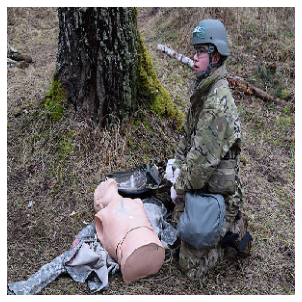

In [12]:
recognized_image, image_topics  = image_recognition_pipeline(     )

In [13]:
#image_topic='dragonfly'

In [14]:
#plt.imshow(recognized_image/255.)

## 2 — Generate semantic word families

For each label, use Word2Vec `similar` to retrieve list of words semantically related to the image object labels

In [15]:
from nltk.corpus import wordnet

def get_synonyms( w ):
    #L = [l.name() if '_' not in l.name() else l.name().split('_') for l in wordnet.synsets( w )[0].lemmas()]  # There may be other synonyms in the synset
    #flattened_list = [w if type()]
    #return L #flattened_list
    return [word for object_name in [syn.name().split('_') for syn in wordnet.synsets( w )[0].lemmas()] for word in object_name]

In [16]:
# get_synonyms( 'oystercatcher' )

In [17]:
# wordnet.synsets( 'oystercatcher' )[0].lemmas()
#get_synonyms( 'ladybug')

## 3 — Generate all related words

For each semantically related (below a distance threshold) word to each object label, measure its phonetic similarity to all words in the dictionary. Also store each words's distance.

For each word in each semantic family, sort and choose the phonetically closest (below a distance threshold) words.
(One way is to convert the word to IPA and compare to an IPA converted version of every word in the CMU dictionary.)

In [18]:
#english_dictionary = ['two', 'pair', 'bear', 'scare', 'you', 'twice', 'hair', 'mice', 'speaker', 'book']

In [19]:
# two_phon_fam = Phon_family(locus_word=Close_word('two', 3), close_words = [Close_word('you', 2.1)])
# two_phon_fam

# pair_phon_fam = Phon_family(locus_word=Close_word('pair', 5), close_words = [Close_word('bear', 1.5), Close_word('hair', 2.7)])
# pair_phon_fam

# twice_phon_fam = Phon_family(locus_word=Close_word('twice', 4.1), close_words = [Close_word('mice', 2.1)])
# twice_phon_fam

In [20]:
from nltk.corpus import words

words_set = set( words.words())
# english_dictionary = words_set

In [21]:
import eng_to_ipa as ipa

def syllable_count_diff( w1, w2 ):
    return abs( ipa.syllable_count( w1 ) - ipa.syllable_count( w2 ))

def same_syllable_count( w1, w2 ):
    return syllable_count_diff(w1, w2) == 0

def close_syllable_count( w1, w2, threshold=2):
    return syllable_count_diff( w1, w2 ) <= threshold

In [22]:
# Eventually will need to to filter for the word-frequency sweet-spot or at least for only Engllish words
# Possibly rewrite with a decororater so that it uses memoization to speed this up

# Rewrite this so it vectorizes the subtraction of the syllable counts

def get_sized_rhymes( w ):
    word_length_min = 2
    rhyme_list = ipa.get_rhymes( w )
    return [ [rhyme for rhyme  in rhyme_list if same_syllable_count( w, rhyme) and len(rhyme) >= word_length_min and rhyme in words_set]]
   

In [23]:
#ipa.isin_cmu('xue')

In [24]:
# get_sized_rhymes('oyster')

In [25]:
import fuzzy
import phonetics
import Levenshtein as lev

soundex = fuzzy.Soundex(4)
dmeta = fuzzy.DMetaphone()

In [26]:
## Temporary stand-in function, to be replaced with one that computes phonetic distance

# https://stackabuse.com/phonetic-similarity-of-words-a-vectorized-approach-in-python/
# "Phonetic Similarity of Words: A Vectorized Approach in Python"

def phonetic_distance(w1, w2):
#     print('fuzzy soundex', lev.distance( soundex(w1), soundex(w2)) )
#     print('fuzzy dmeta  ', lev.distance( dmeta(w1)[0], dmeta(w2)[0]) )
#     print('phon dmet    ', lev.distance( phonetics.dmetaphone(w1)[0], phonetics.dmetaphone(w2)[0]) )
#     print('phon met     ', lev.distance( phonetics.metaphone(w1), phonetics.metaphone(w2)) )
#     print('fuzzy nysiis ', lev.distance( fuzzy.nysiis(w1), fuzzy.nysiis(w2)) )
#     print('phon nysiis  ', lev.distance( phonetics.nysiis(w1), phonetics.nysiis(w2)) )
#     soundex_dist = lev.distance( soundex(w1), soundex(w2))
    nysiis_dist = lev.distance( fuzzy.nysiis(w1), fuzzy.nysiis(w2))
    try:
        dmeta_dist  = lev.distance( dmeta(w1)[0], dmeta(w2)[0])
        return np.mean( np.array([  dmeta_dist, nysiis_dist]) )
    except:
        return nysiis_dist

In [27]:
def syllable_penalty(w1, w2, penalty_factor = 0.2):
    return syllable_count_diff( w1, w2 ) * penalty_factor

In [28]:
def last_letter_discount(w1, w2, discount_value = .25):
    return discount_value if w1[-1] == w2[-1] else 0

In [29]:
from random import random


# Are these three lines necessary?
two_fam_member_list = ['you']
pair_fam_member_list = ['bear', 'hair']
twice_fam_member_list = ['mice']

def make_phon_fam_for_sem_fam_member( w_record, thresh=3 ):
    w_phon_code = w_record.word # To be replaced with phonetic version if needed
    close_word_list = []
    rhyme_dist = .3
    non_rhyme_penalty = rhyme_dist + .3
    
    # Find words that are not necessarily rhyms but phonetically similar
    for word in words_set:
        phon_dist = phonetic_distance( word, w_record.word) 
        if (phon_dist <= thresh) and (word != w_record.word):
            syll_pen = syllable_penalty( word, w_record.word)
            last_let_disc = last_letter_discount(word, w_record.word)
            close_word_list.append( Close_word(word.lower(), phon_dist + non_rhyme_penalty + syll_pen - last_let_disc ))
    

    rhyme_word_list = get_sized_rhymes( w_record.word )[0]
    
    # Find words that are rhymes
    for word in rhyme_word_list:
            syll_pen = syllable_penalty( word, w_record.word)
            last_let_disc = last_letter_discount(word, w_record.word)
            close_word_list.append( Close_word(word, rhyme_dist + syll_pen - last_let_disc) )
    
    
    return Phon_family(locus_word = w_record, close_words=close_word_list )
    
    

In [30]:
# two_phon_fam = get_phon_fam_for_sem_fam_member( 'two' )
# pair_phon_fam = get_phon_fam_for_sem_fam_member( 'pair' )
# twice_phon_fam = get_phon_fam_for_sem_fam_member( 'twice' )


In [31]:
## ALERT:  Need to incorporate the semantic distance somewhere

In [32]:
# two_sem_fam = Sem_family(locus_word='two', phon_fams = [make_phon_fam_for_sem_fam_member( 'two' ), \
#                                                         make_phon_fam_for_sem_fam_member( 'pair' ), \
#                                                         make_phon_fam_for_sem_fam_member( 'twice' )])

In [33]:
# To be replaced with Word2Vec `most_similar()`

# def get_most_similar_obsolete( w ):  
#     list_of_duples =  [('pair', .95), ('twice', .90)]
#     list_of_close_words = [Close_word( word=w_str, distance= 1 - w_sim) for w_str, w_sim in list_of_duples ]
        
#     return list_of_close_words

In [34]:
def get_most_similar( w ):  
    synonym_dist_setting = .6
    list_of_duples = [(syn, synonym_dist_setting) for syn in get_synonyms( w )]
    if(w == 'two'):
        additional_words =  [('pair', .95), ('twice', .90)]
        list_of_duples.extend( additional_words )
    list_of_close_words = [Close_word( word=w_str, distance= w_sim) for w_str, w_sim in list_of_duples ]
        
    return list_of_close_words

In [35]:
# get_most_similar( 'oyster' )

In [36]:
def make_phon_fams_and_sem_family( w ):
    word_record_ = Close_word(w, 0.0)
    
    sem_sim_words = get_most_similar( w )  # Eventually replace with call to Word2Vec
    
    #phon_fams_list = [make_phon_fam_for_sem_fam_member( word_record_  )]
    phon_fams_list = []

    
    for close_w_record in sem_sim_words:
        print( close_w_record )
        phon_fams_list.append( make_phon_fam_for_sem_fam_member( close_w_record ) )
    
    return Sem_family(locus_word= word_record_, sem_fam_words = phon_fams_list)
   
 

In [37]:
# make_phon_fams_and_sem_family('soccer')

In [38]:
# two_sem_fam = make_phon_fams_and_sem_family('two')
# two_sem_fam

## 4 — Gather candidate phrases

For each word in the phonetic family, of each word in the semantic family, of each object label, retrieve phrases containing the word.
Add the phrase_Id, as well as the stats on the object centrality, semantic distance, and phonetic distance, to a dataframe.

Compute _suitability score_ for each word-phrase match and add this to that column of the dataframe

Also, for each word in the semantic family, search the joke list for match and add that these to a joke_match dataframe, to use if there's too low a suitability score using a substitution.


In [39]:
# get_most_similar('soccer')

## TO CODE NEXT

Write code that takes the word `twice` and returns its `semantic_family` which is a list of words 
('pair', and 'twice' in this case) and returns either (TBD) the list phonetically similar words or 
the pboneticized version of the word to be compared with the phoneticized variants of words in
the phrases



#### Define dataframe for candidate phrases

In [40]:
# col_names = ['semantic_match', 'sem_dist', 'phonetic_match', 'phon_dist', 'phrase_id', 'dist_score']

# cand_df = pd.DataFrame(columns= col_names)
# cand_df

#### Need to write body of function that will convert to phoneticized version of word

In [41]:
def phoneticized( w ):
    return w

### ALERT:  Instead, pre-generate a dictionary of phoneticized versions of the words in the list of idioms. Each phonetic word should map to a list of duples each of which is a phrase id and the corresponding word

In [42]:
def get_matching_phrases( w, phrase_dict_ ):
#     with open("data/" + "phrase_dictionary.pickle", 'rb') as to_read:
#         phrase_dict_ =  pickle.load(to_read)
    
    matched_id_list = []
    for phrase_id in phrase_dict_.keys():
        if w in phrase_dict_[phrase_id].phon_list:
            matched_id_list.append(phrase_id)
            print( phrase_dict_[ phrase_id] )
            return matched_id_list

In [43]:
# get_matching_phrases('oyster') 

In [44]:
#  cycles through each phonetic family in the semantic family to get matching phrases

#def get_phrases_for_phon_fam( phon_fam_, sem_dist_ ):
def get_phrases_for_phon_fam( phon_fam_, phrase_dict_ ):

    word_match_records_ = []

    #phon_fam_ = pair_phon_fam
    for word in phon_fam_.close_words:
        matched_phrases = get_matching_phrases( word.word, phrase_dict_ )
        #print(word, len(matched_phrases))
        if matched_phrases:
            for p_id in matched_phrases:
                word_match_records_.append({'semantic_match': phon_fam_.locus_word.word, 'sem_dist': phon_fam_.locus_word.distance, 'phonetic_match': word.word, 'phon_dist': word.distance, 'phrase_id': p_id, 'dist_score': ''})
    return word_match_records_ 


In [45]:
def get_phrases_for_sem_fam( sem_fam_, phrase_dict_ ):
    word_match_records_ = []
    for phon_fam_ in sem_fam_.sem_fam_words:
        print( phon_fam_.locus_word.distance )
        #word_match_records_.extend( get_phrases_for_phon_fam( phon_fam_, sem_fam_.locus_word.distance ) )
        phrases_ = get_phrases_for_phon_fam( phon_fam_, phrase_dict_ ) 

        if len( phrases_ ) > 0:
            print( phrases_ )
            word_match_records_.extend( phrases_ )
    return word_match_records_

In [46]:
# word_match_records = []   

# word_match_records.extend( get_phrases_for_phon_fam( two_phon_fam ) ) 
# word_match_records.extend( get_phrases_for_phon_fam( pair_phon_fam ) )
# word_match_records.extend( get_phrases_for_phon_fam( twice_phon_fam ) )  
# word_match_records

In [47]:
#cand_df = cand_df.append(word_match_records)

In [48]:
#two_sem_fam

In [49]:
# word_match_records = get_phrases_for_sem_fam( two_sem_fam )
# word_match_records

In [50]:
# To be replaced with image recognition algorithms
def get_image_topics():
    return [image_topic]
    #return [test_image_topic]

## The equivalent of `main` for the time being, until two or more image topics are handled

In [51]:
#image_topics_list = []
#image_topic_word = ''

#def generate_the_caption(cand_df_, image_topics_list_, image_topic_word_):
#def generate_the_caption(cand_df_ ):
#def generate_the_caption( image_topics_ ):
def generate_the_caption( ):
    with open("data/" + "image_topics.pickle", 'rb') as to_read:
        image_topics_ =  pickle.load(to_read)
        
    with open("data/" + "phrase_dictionary.pickle", 'rb') as to_read:
        phrase_dict_ =  pickle.load(to_read)    
    
    col_names = ['semantic_match', 'sem_dist', 'phonetic_match', 'phon_dist', 'phrase_id', 'dist_score']
    cand_df_ = pd.DataFrame(columns= col_names)
    #cand_df
    
#    image_topics_list_     = get_image_topics()
#    image_topic_word_ = image_topics_list_[0]
    #image_topic_word = 'boy'

    image_topic_word_ = image_topics_[0]
    image_sem_fam = make_phon_fams_and_sem_family( image_topic_word_ )
    #two_sem_fam

    word_match_records = get_phrases_for_sem_fam( image_sem_fam, phrase_dict_ )

    cand_df_ = cand_df_.append(word_match_records)
    return cand_df_, image_topic_word_

cand_df, image_topic_word = generate_the_caption()
#cand_df, image_topic_word = generate_the_caption(image_topics)
#cand_df, image_topics_list, image_topic_word = generate_the_caption(cand_df)

Close_word(word='military', distance=0.6)
Close_word(word='uniform', distance=0.6)
0.6
Phrase(text_string='guilty pleasure', word_list=['guilty', 'pleasure'], phon_list=['guilty', 'pleasure'], string_length=15, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='your mileage may vary', word_list=['your', 'mileage', 'may', 'vary'], phon_list=['your', 'mileage', 'may', 'vary'], string_length=21, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='rob peter to pay paul', word_list=['rob', 'peter', 'to', 'pay', 'paul'], phon_list=['rob', 'peter', 'to', 'pay', 'paul'], string_length=21, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='hail mary (n. or adj.)', word_list=['hail', 'mary', '(n.', 'or', 'adj.)'], phon_list=['hail', 'mary', '(n.', 'or', 'adj.)'], string_length=22, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='mad as a hatter', word_list=['ma

Phrase(text_string='give someone the cold shoulder', word_list=['give', 'someone', 'the', 'cold', 'shoulder'], phon_list=['give', 'someone', 'the', 'cold', 'shoulder'], string_length=30, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='butter wouldn’t melt in (someone’s)', word_list=['butter', 'wouldn’t', 'melt', 'in', '(someone’s)'], phon_list=['butter', 'wouldn’t', 'melt', 'in', '(someone’s)'], string_length=35, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='victory lap', word_list=['victory', 'lap'], phon_list=['victory', 'lap'], string_length=11, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='from pillar to post', word_list=['from', 'pillar', 'to', 'post'], phon_list=['from', 'pillar', 'to', 'post'], string_length=19, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='rob peter to pay paul', word_list=['rob', 'peter', 'to', 'pay', 'paul']

Phrase(text_string='elephant in the room', word_list=['elephant', 'in', 'the', 'room'], phon_list=['elephant', 'in', 'the', 'room'], string_length=20, word_count=4, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='quote unquote', word_list=['quote', 'unquote'], phon_list=['quote', 'unquote'], string_length=13, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='shoot oneself in the foot', word_list=['shoot', 'oneself', 'in', 'the', 'foot'], phon_list=['shoot', 'oneself', 'in', 'the', 'foot'], string_length=25, word_count=5, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='twenty-four seven', word_list=['twenty-four', 'seven'], phon_list=['twenty-four', 'seven'], string_length=17, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='even steven', word_list=['even', 'steven'], phon_list=['even', 'steven'], string_length=11, word_count=2, prefix='Yeah, right, like  ', phrase_type='

Phrase(text_string='banner year', word_list=['banner', 'year'], phon_list=['banner', 'year'], string_length=11, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='eager beaver', word_list=['eager', 'beaver'], phon_list=['eager', 'beaver'], string_length=12, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='amber gambler', word_list=['amber', 'gambler'], phon_list=['amber', 'gambler'], string_length=13, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='don’t judge a book by its cover', word_list=['don’t', 'judge', 'a', 'book', 'by', 'its', 'cover'], phon_list=['don’t', 'judge', 'a', 'book', 'by', 'its', 'cover'], string_length=31, word_count=7, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='in clover', word_list=['in', 'clover'], phon_list=['in', 'clover'], string_length=9, word_count=2, prefix='Yeah, right, like  ', phrase_type='idiom')
Phrase(text_string='ano

In [52]:
#image_sem_fam.sem_fam_words[0]

In [53]:
#test_sem_fam_word = image_sem_fam.sem_fam_words[1]
#test_sem_fam_word

In [54]:
#test_sem_fam_word.close_words

In [55]:
#get_sized_rhymes('soccer')

In [56]:
#test_sem_fam_word.close_words[0].word

In [57]:
#print( get_matching_phrases( 'life') )

In [58]:
#print( get_matching_phrases( test_sem_fam_word.close_words[0].word ) )

In [59]:
#image_sem_fam.sem_fam_words[2]

In [60]:
# cand_df = pd.DataFrame({"semantic_match": ['pair','pair','twice'], "sem_dist": [5, 5, 4.1], "phonetic_match": ['bear', 'hair','mice'], "phon_dist": [1.5, 2.7, 2.1], "phrase_id":  [ph_id1, ph_id2,ph_id3], "phrase_type":  ['idiom', 'idiom','idiom'],'score': [.5, .3, 1.1]})


In [61]:
# cand_df

In [70]:
def compute_candidate_caption_scores(cand_df_):
    cand_df_['dist_score'] = cand_df_.apply(lambda row: float(row['sem_dist'] + row['phon_dist']), axis=1)
    return cand_df_


# def compute_candidate_caption_scores(cand_df_):
#     cand_df_['dist_score'] = cand_df_.apply(lambda row: float(row['sem_dist'] + row['phon_dist']), axis=1)
#     cand_df_
#     return cand_df_
    
cand_df = compute_candidate_caption_scores(cand_df)
# cand_df

## 5 —  Choose captions

Sort captions dataframe by the _suitability score_

Choose the top 10(?) and generate a list containing each caption with the original semantic family word substituted into the idiom in addition to jokes containing any of the semantic family words

In [71]:
def sub_raw_string(phrase_string, orig_word='', new_word=''):
    return phrase_string.replace(orig_word, new_word)

In [72]:
def sub(phrase, orig_word='', new_word=''):
    return phrase.text_string.replace(orig_word, new_word)

In [73]:
# phrase_string = 'Wild Goose Chase'
# sub_raw_string(phrase_string, 'wild', 'child')

In [74]:
def construct_caption( row ):
    return sub( phrase_dict[ row['phrase_id']], row['phonetic_match'],  row['semantic_match']  )

In [75]:
def get_best_captions(df, selection_size=25):
    df.sort_values(by='dist_score', inplace=True)
    best_df = df.head(selection_size)
    #best_df['caption'] = best_df.apply(construct_caption, axis=1 )
    best_df.loc[:, 'caption'] = best_df.apply(construct_caption, axis=1 ) 
    return best_df
    #return best_df['_caption'].to_list()

In [76]:

cand_df

,semantic_match,sem_dist,phonetic_match,phon_dist,phrase_id,dist_score
0,military,0.6,pleasure,4.00,4aea96f0-83aa-11eb-90b8-acde48001122,4.60
1,military,0.6,mileage,4.00,4aeb4c26-83aa-11eb-90b8-acde48001122,4.60
2,military,0.6,peter,4.00,4aeafc62-83aa-11eb-90b8-acde48001122,4.60
3,military,0.6,mary,3.75,4aea9bb4-83aa-11eb-90b8-acde48001122,4.35
4,military,0.6,hatter,4.00,4aead610-83aa-11eb-90b8-acde48001122,4.60
...,...,...,...,...,...,...
103,uniform,0.6,snuff,4.00,4aeb3f38-83aa-11eb-90b8-acde48001122,4.60
104,uniform,0.6,until,3.80,4aeb3d94-83aa-11eb-90b8-acde48001122,4.40
105,uniform,0.6,upper,3.80,4aeac53a-83aa-11eb-90b8-acde48001122,4.40
106,uniform,0.6,number,3.80,4aeb4c4e-83aa-11eb-90b8-acde48001122,4.40


In [77]:
def process_best_captions_df_and_make_list(cand_df):
    best_captions_df = get_best_captions(cand_df)
    best_captions_df
    best_captions_list = [caption.capitalize() for caption in best_captions_df['caption'].to_list()]
    return best_captions_df, best_captions_list

In [78]:
best_captions_df, best_captions_list = process_best_captions_df_and_make_list(cand_df)


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [79]:
best_captions_df

,semantic_match,sem_dist,phonetic_match,phon_dist,phrase_id,dist_score,caption
63,uniform,0.6,never,2.30,4aea4cb8-83aa-11eb-90b8-acde48001122,2.90,better late than uniform
20,military,0.6,territory,2.35,4aeb40be-83aa-11eb-90b8-acde48001122,2.95,virgin military
98,uniform,0.6,another,2.60,4aea31c4-83aa-11eb-90b8-acde48001122,3.20,uniform nail in one’s coffin
80,uniform,0.6,under,2.80,4aea484e-83aa-11eb-90b8-acde48001122,3.40,be snowed uniform
24,military,0.6,letter,3.00,4aeacd0a-83aa-11eb-90b8-acde48001122,3.60,military of the law
36,military,0.6,history,3.05,4aea3002-83aa-11eb-90b8-acde48001122,3.65,ancient military
45,military,0.6,slippery,3.05,4aeb0d2e-83aa-11eb-90b8-acde48001122,3.65,military slope
58,uniform,0.6,interim,3.05,4aeabdce-83aa-11eb-90b8-acde48001122,3.65,in the uniform
102,uniform,0.6,injury,3.10,4aea2274-83aa-11eb-90b8-acde48001122,3.70,add insult to uniform
69,uniform,0.6,amateur,3.10,4aea2e54-83aa-11eb-90b8-acde48001122,3.70,uniform hour


In [80]:
def get_display_df(best_captions_df_):
    best_captions_display_df = best_captions_df_[['caption', 'dist_score', 'semantic_match', 'sem_dist', 'phonetic_match', 'phon_dist']]
    best_captions_display_df['caption'] =best_captions_display_df['caption'].apply(lambda x: x.capitalize())
    best_captions_display_df.set_index('caption', inplace=True)
    best_captions_display_df
    return best_captions_display_df
    
display_df = get_display_df( best_captions_df )
display_df


<ipython-input-80-de1c461873bf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_captions_display_df['caption'] =best_captions_display_df['caption'].apply(lambda x: x.capitalize())


,dist_score,semantic_match,sem_dist,phonetic_match,phon_dist
caption,,,,,
Better late than uniform,2.90,uniform,0.6,never,2.30
Virgin military,2.95,military,0.6,territory,2.35
Uniform nail in one’s coffin,3.20,uniform,0.6,another,2.60
Be snowed uniform,3.40,uniform,0.6,under,2.80
Military of the law,3.60,military,0.6,letter,3.00
Ancient military,3.65,military,0.6,history,3.05
Military slope,3.65,military,0.6,slippery,3.05
In the uniform,3.65,uniform,0.6,interim,3.05
Add insult to uniform,3.70,uniform,0.6,injury,3.10


In [81]:
#image_topic_word

In [82]:
import matplotlib.image as mpimg
img = mpimg.imread('data/temp.png')

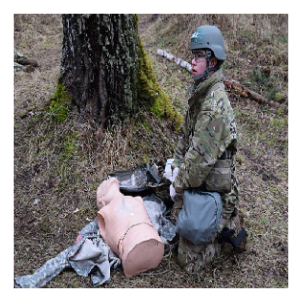

In [83]:
ax = plt.axes([0,0,1,1], frameon=False)

# Then we disable our xaxis and yaxis completely. If we just say plt.axis('off'),
# they are still used in the computation of the image padding.
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Even though our axes (plot region) are set to cover the whole image with [0,0,1,1],
# by default they leave padding between the plotted data and the frame. We use tigher=True
# to make sure the data gets scaled to the full extents of the axes.
plt.autoscale(tight=True)

ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

#plt.imshow(recognized_image/255.)
#plt.imshow(global_var_img/255.)
plt.imshow(img)


In [84]:
best_captions_list 

['Better late than uniform',
 'Virgin military',
 'Uniform nail in one’s coffin',
 'Be snowed uniform',
 'Military of the law',
 'Ancient military',
 'Military slope',
 'In the uniform',
 'Add insult to uniform',
 'Uniform hour',
 'Age uniform beauty',
 'Military hour',
 'An uniform one can’t refuse',
 'Mother uniform',
 'Uniform back',
 'Military the goods',
 'Hell for military',
 'Give someone the cold military',
 'Uniform of life',
 'Cut the military',
 'And his military',
 'Military lap',
 'Busman’s military',
 'Uniform dog has his',
 'Push the uniform']

In [85]:
image_topic

NameError: name 'image_topic' is not defined

In [86]:
def make_image_with_caption( image, caption):
  ax = plt.subplot(1, 1, 1)
  plt.axis('off')
  plt.text( 0.5, -0.1, caption, \
    horizontalalignment='center', verticalalignment='center', \
    transform=ax.transAxes, fontsize=16)
  plt.imshow( image)

  plt.tight_layout()
  plt.savefig('data/image_with_caption.png')
  plt.show()





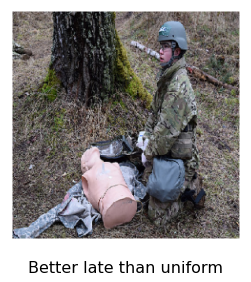

In [87]:
# longer_caption = 'Box in the henhouse (chickenhouse) Box in the henhouse (chickenhouse)'
#plot_image( img, longer_caption)

make_image_with_caption( img, best_captions_list[0])

In [88]:
# THIS BLOCK OF CODE ONLY WHEN THE APP LAUNCHES    

# @st.cache
def setup():
	seed_the_phrase_dictionary_with_examples()

	#idiom_list_ = compile_idiom_lists(idiom_list_)
	idiom_list_ = compile_idiom_lists()
    
	build_phrase_dictionary(idiom_list_)

In [ ]:
#def process_next_image( idiom_list_, cand_df_ ):
def process_captioning_the_image(  ):




    
# THIS BLOCK OF CODE EACH TIME A NEW IMAGE IS CHOSEN    
	#recognized_image, image_topics_  = image_recognition_pipeline( )
	#image_recognition_pipeline( )
    
# THIS BLOCK OF CODE EACH TIME STREAMLIT REFRESHES    
    # Are we actually using `image_topics_list` after this?
	cand_df_, image_topic_word_ = generate_the_caption()
	#cand_df_, image_topic_word_ = generate_the_caption(image_topics_)
	#cand_df_, image_topics_list, image_topic_word = generate_the_caption(cand_df_)

	cand_df_ = compute_candidate_caption_scores(cand_df_)

	best_captions_df = get_best_captions(cand_df_)

	best_captions_df, best_captions_list = process_best_captions_df_and_make_list(cand_df_)

	img = mpimg.imread('data/temp.png')

	make_image_with_caption( img, best_captions_list[0])

	display_df_ = get_display_df( best_captions_df )
    
	return display_df_
	#return cand_df_, display_df


In [ ]:
def display_image():
    img = mpimg.imread('data/image_with_caption.png')
    st.image(img, width=800)

### Streamlit code

### non-streamlit code

### Streamlit code

### Non-streamlit code

In [ ]:
get_best_captions(cand_df)

In [ ]:
image_topic